In [1]:
require 'nn'
require 'cunn'
require 'image'
matio = require 'matio'

nUtils = dofile('../modules/netUtils.lua')
vUtils = dofile('../modules/visUtils.lua')
mUtils = dofile('../modules/meshUtils.lua')
primitives = dofile('../modules/primitives.lua')
demoUtils = dofile('../demo/demoUtils.lua')

params = {}
params.gridSize = 32 --we trained our CNNs to predict using this voxel grid size input
params.gridBound = 0.5 --the meshes are normalized between [-gridBund, gridBound]
params.primTypes = {'Cu','Nu'} -- the trained CNNs outputs each primitive as a 'Cuboid' or 'Null' (non-existent)
blendFile = '../renderer/model.blend' -- needed for rendering
blenderExec = '/home/eecs/shubhtuls/Downloads/blender-2.71/blender'

In [2]:
params.synset = '03001627' --synset id for chairs
params.name = 'chairNet' --name of the CNN
params.numTrainIter = 30000
params.modelsDir = '../demo/data/' .. params.synset .. '/' --directory where the .mat files containing input voxels are stored.
params.visMeshesDir = '../cachedir/resultsDir/' .. params.name .. '/' --directory where the meshes, rendrings should be saved
paths.mkdir(params.visMeshesDir)

In [4]:
local snapshotDir = '../cachedir/snapshots/' .. params.name -- directory where CNN is saved
if(not paths.filep(snapshotDir .. '/iter' .. tostring(params.numTrainIter) .. '.t7')) then
    local webLink = 'https://people.eecs.berkeley.edu/~shubhtuls/cachedir/primitives/chairNet/iter30000.t7'
    paths.mkdir(snapshotDir)
    require 'os'
    local command = string.format('wget %s; mv iter30000.t7 %s/', webLink, snapshotDir)
    print(command)
    os.execute(command)
end
netPred = torch.load(snapshotDir .. '/iter' .. tostring(params.numTrainIter) .. '.t7')
netPred:evaluate()
netPred:apply(nUtils.setTestMode)

In [5]:
---------Data Loading----------
-------------------------------
modelName = '11c9c57efad0b5ec297936c81e7f6629.mat' -- or '117c0e0aafc0c3f81015cdff13e6d9f3.mat' or '4aafa7600e0aacbf7b11ae648ea92233.mat'
shapeVar = matio.load(paths.concat(params.modelsDir, modelName),{'Volume','vertices','faces'})
volInp = torch.Tensor(2,1,params.gridSize ,params.gridSize, params.gridSize):fill(0)
volInp[1]:copy(shapeVar.Volume:double())
volInp = volInp:cuda()

In [6]:
---------Prediction------------
-------------------------------
predParams = netPred:forward(volInp) -- Prediction of cuboid configuration
partVols = {}
for px = 1,#predParams do
    partVols[px] = mUtils.shapeVolume(predParams[px][1][1]:clone():double(), params.primTypes)
    predParams[px] = {
        predParams[px][1]:narrow(1,1,1):clone():double(),
        predParams[px][2]:narrow(1,1,1):clone():double(),
        predParams[px][3]:narrow(1,1,1):clone():double()
    }
end

-- Simplification (remove parts which intersect with others a lot)
predParams, partVols = demoUtils.removeRedundantParts(predParams, partVols, params.primTypes)


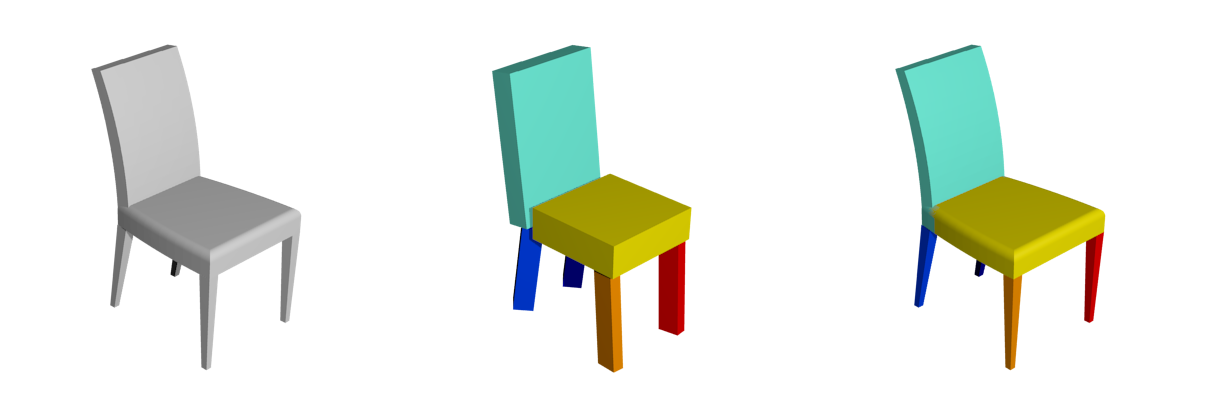

In [7]:
--------Visualization----------
-------------------------------
local imgsVis = torch.Tensor(3,3,400,400)
-- The ground-truth mesh
local mName = modelName:split('.mat$')[1]
local gtMesh = params.visMeshesDir .. mName .. '_gt.obj'
local gtPng = params.visMeshesDir .. mName .. '_gt.png'    
mUtils.writeObj(gtMesh, shapeVar.vertices, shapeVar.faces)
mUtils.renderMesh(blenderExec, blendFile, gtMesh, gtPng)
local im = image.crop(vUtils.RGBAtoRGB(image.load(gtPng)), 350, 1, 750, 401)
imgsVis[1]:copy(im)

-- The predicted cuboid configuration
local predMesh = params.visMeshesDir .. mName .. '_pred.obj'
local predPng = params.visMeshesDir .. mName .. '_pred.png'
mUtils.saveParts(predParams, predMesh , params.primTypes)
mUtils.renderMesh(blenderExec, blendFile, predMesh, predPng)
local im = image.crop(vUtils.RGBAtoRGB(image.load(predPng)), 350, 1, 750, 401)
imgsVis[2]:copy(im)

-- The mesh parse inferred by computing for each mesh triangle the corresponding cuboid index
local parseMesh = params.visMeshesDir .. mName .. '_parse.obj'
local parsePng = params.visMeshesDir .. mName .. '_parse.png'

local faceInds = demoUtils.meshFaceInds(predParams, partVols, shapeVar, params.primTypes)
mUtils.saveParse(parseMesh, shapeVar.vertices, shapeVar.faces, faceInds:clone(), #predParams)
mUtils.renderMesh(blenderExec, blendFile, parseMesh, parsePng)
local im = image.crop(vUtils.RGBAtoRGB(image.load(parsePng)), 350, 1, 750, 401)
imgsVis[3]:copy(im)

itorch.image(imgsVis)